In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Needed for advanced plotting
import matplotlib.patches as patches

# For plotting inline
%matplotlib inline
plt.ion()

In [2]:
# Import suftware (use development copy)
import sys
sys.path.append('..')

import suftware as sw

In [3]:
# Set default plotting parameters
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rc('text', usetex=True)
fontsize=9
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['hatch.linewidth'] = 1
mpl.rcParams['hatch.color'] = 'black'

In [4]:
# Load raw information extracted from figure
raw_df = pd.read_excel('data/CMS2012.xlsx').fillna(0)

In [5]:
# Clean up dataframe
df = raw_df[['bins','data']].copy()
df['bg'] = raw_df['green']+raw_df['blue-green']
df['bg+H'] = df['bg'] + raw_df['red-blue']
df.head()

,bins,data,bg,bg+H
0,72,1.0,0.181,0.181
1,75,0.0,0.249,0.249
2,78,0.0,0.383,0.383
3,81,0.0,0.666,0.666
4,84,0.0,1.323,1.323


In [6]:
# How many of each type of event (bg or H) are expected?
expected_N_tot = df['bg+H'].sum()
expected_N_bg = df['bg'].sum()
expected_N_H = expected_N_tot-expected_N_bg
print('Expected N_tot: %.1f +/- %.1f'%(expected_N_tot,np.sqrt(expected_N_tot)))
print('Expected N_bg: %.1f +/- %.1f'%(expected_N_bg,np.sqrt(expected_N_bg)))
print('Expected N_H: %.1f +/- %.1f'%(expected_N_H,np.sqrt(expected_N_H)))
print('N_H / N_tot: %.1f%%'%(100*expected_N_H/expected_N_tot))

Expected N_tot: 71.3 +/- 8.4
Expected N_bg: 63.9 +/- 8.0
Expected N_H: 7.4 +/- 2.7
N_H / N_tot: 10.3%


In [7]:
# Generate data so SUFTware can histogram it again. Shouldn't have to do this.
data = []
for n, row in df.iterrows():
    data.extend([row['bins']]*int(row['data']))
grid = df['bins'].values

print('Dataset: %s'%repr(data))

Dataset: [72.0, 87.0, 87.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 93.0, 93.0, 93.0, 93.0, 93.0, 96.0, 96.0, 96.0, 96.0, 96.0, 99.0, 99.0, 99.0, 102.0, 114.0, 117.0, 120.0, 123.0, 123.0, 123.0, 126.0, 126.0, 126.0, 126.0, 129.0, 129.0, 132.0, 132.0, 138.0, 141.0, 144.0, 147.0, 147.0, 153.0, 156.0, 162.0, 165.0, 165.0, 165.0, 168.0, 174.0, 174.0, 177.0, 177.0, 180.0, 180.0, 180.0]


In [8]:
# Do density estimation
num_samples = 1000
density = sw.DensityEstimator(data=data,grid=grid,num_posterior_samples=num_samples, seed=0)

In [9]:
# Extract information to plot
bins = df['bins'].values
hist = df['data'].values
bg = df['bg'].values
bgH = df['bg+H'].values

N = df['data'].sum()
h = bins[1]-bins[0]

# Create xs to interpolate density on
xmin, xmax = density.bounding_box
xs = np.linspace(xmin,xmax,1000)

# Compute estimated densitya nd fluctuations
count_density = N*h*density.evaluate(xs)
count_fluctuations = N*h*density.evaluate_samples(xs)

In [10]:
xlim = density.bounding_box
ylim = [0,12]
def plot_higgs(ax, zorder=0):
    """
    Function to plot Higgs data similar to in CMS Collaboration, 2012, Fig. 3
    """
    
    # Plot Higgs prediction
    ax.step(bins,bgH,
           label='Higgs boson',
           where='mid',
           color='red',
           linewidth=1,
           zorder=zorder)

    # Plot background
    fill_blue=[.60,.81,1.00]
    ax.bar(bins,bg,
           label='background',
           width=h,
           color='lightskyblue',
           zorder=zorder)
    ax.step(bins,bg,color='k',linewidth=1,where='mid',zorder=zorder)
    
    # Plot data
    ax.plot(bins,hist, 
            markersize=3, 
            marker='o', 
            color='k',
            linewidth=0,
            label='data',
            zorder=zorder+1)

    # Style plot
    ax.set_xlim(xlim)
    ax.set_ylabel('events / 3 GeV')
    ax.set_ylim(ylim)
    yticks = np.arange(ylim[1]+1)
    yticklabels = [('%d'%y if y%2==0 else '') for y in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    #ax.legend()
    #ax.minorticks_on()
    
    # Label x axis
    ax.set_xlabel('$m_{4 \ell}$ (GeV)')

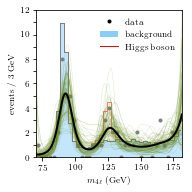

In [11]:
# Make summary figure for blurb
fig, ax = plt.subplots(1,1,figsize=[2.5,2.5])
plot_higgs(ax, zorder=-10)

# Create a Rectangle patch
rect = patches.Rectangle((xlim[0],ylim[0]),
                         xlim[1]-xlim[0],
                         ylim[1]-ylim[0],
                         facecolor='white',
                         edgecolor='white',
                         alpha=.5,
                         zorder=-1)

# Add the patch to the Axes
ax.add_patch(rect)

# Set number of posterior samples to show
num_samples_to_show=100

# Plot DEFT fluctuations
ax.plot(xs,100+count_fluctuations[:,0], 
        linewidth=.5, 
        alpha=1, 
        color='olivedrab',
        label='DEFT: $Q \sim p(Q|\mathrm{data})$',
        zorder=-1) # Dummy plot just for legend entry
ax.plot(xs,count_fluctuations[:,:num_samples_to_show], 
        linewidth=.5, 
        alpha=.2, 
        color='olivedrab',
        zorder=-1) 

# Plot DEFT best fit
ax.plot(xs,count_density, 
        label='DEFT',
        linewidth=2,
        color='black',
        alpha=1,
        zorder=0)

# Prepare legend
handles,labels = ax.get_legend_handles_labels()
indices= [1,4,0] #[0,1,2,3,4]
labels = [labels[i] for i in indices]
handles = [handles[i] for i in indices]
ax.legend(handles,labels, fontsize=9, frameon=False)

# Do tight layout
plt.tight_layout(pad=0.1)

fig.savefig('figures/fig_summary.png', dpi=200)

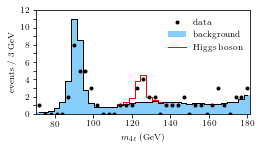

In [12]:
figsize=[16/4.5,9/4.5]

### Make data figure for video release
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_higgs(ax, zorder=-10)

# Create a Rectangle patch
rect = patches.Rectangle((xlim[0],ylim[0]),
                         xlim[1]-xlim[0],
                         ylim[1]-ylim[0],
                         facecolor='white',
                         edgecolor='white',
                         #alpha=.5,
                         alpha=0,
                         zorder=-1)

# Add the patch to the Axes
ax.add_patch(rect)

# Set number of posterior samples to show
num_samples_to_show=100

# Plot DEFT fluctuations
ax.plot(xs,100+count_fluctuations[:,0], 
        linewidth=.5, 
        #alpha=1, 
        alpha=0,
        color='olivedrab',
        label='DEFT: $Q \sim p(Q|\mathrm{data})$',
        zorder=-1) # Dummy plot just for legend entry
ax.plot(xs,count_fluctuations[:,:num_samples_to_show], 
        linewidth=.5, 
        #alpha=.2,
        alpha=0,
        color='olivedrab',
        zorder=-1) 

# Plot DEFT best fit
ax.plot(xs,count_density, 
        label='DEFT',
        linewidth=2,
        color='black',
        #alpha=1,
        alpha=0,
        zorder=0)

# Prepare legend
handles,labels = ax.get_legend_handles_labels()
indices= [1,4,0] #[0,1,2,3,4]
labels = [labels[i] for i in indices]
handles = [handles[i] for i in indices]
ax.legend(handles,labels, fontsize=9, frameon=False)

# Do tight layout
plt.tight_layout(pad=0.5)

fig.savefig('figures/fig_video_data.pdf')

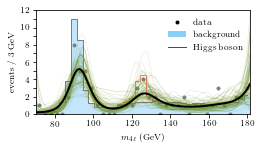

In [13]:
### Make fit figure for video release
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_higgs(ax, zorder=-10)

# Create a Rectangle patch
rect = patches.Rectangle((xlim[0],ylim[0]),
                         xlim[1]-xlim[0],
                         ylim[1]-ylim[0],
                         facecolor='white',
                         edgecolor='white',
                         alpha=.5,
                         #alpha=0,
                         zorder=-1)

# Add the patch to the Axes
ax.add_patch(rect)

# Set number of posterior samples to show
num_samples_to_show=100

# Plot DEFT fluctuations
ax.plot(xs,100+count_fluctuations[:,0], 
        linewidth=.5, 
        alpha=1, 
        color='olivedrab',
        label='DEFT: $Q \sim p(Q|\mathrm{data})$',
        zorder=-1) # Dummy plot just for legend entry
ax.plot(xs,count_fluctuations[:,:num_samples_to_show], 
        linewidth=.5, 
        alpha=.2,
        color='olivedrab',
        zorder=-1) 

# Plot DEFT best fit
ax.plot(xs,count_density, 
        label='DEFT',
        linewidth=2,
        color='black',
        alpha=1,
        zorder=0)

# Prepare legend
handles,labels = ax.get_legend_handles_labels()
indices= [1,4,0] #[0,1,2,3,4]
labels = [labels[i] for i in indices]
handles = [handles[i] for i in indices]
ax.legend(handles,labels, fontsize=9, frameon=False)

# Do tight layout
plt.tight_layout(pad=0.5)

fig.savefig('figures/fig_video_fit.pdf')

Running /Users/jkinney/anaconda3/lib/python3.6/site-packages/suftware/docs/example_alcohol.py:
-------------------------------------------------------------
import suftware as sw

# Retrieve data included with SUFTware
dataset = sw.ExampleDataset('who.alcohol_consumption')

# Perform one-dimensional density estimation
density = sw.DensityEstimator(dataset.data)

# Plot results and annotate with metadata
density.plot(title=dataset.description, xlabel=dataset.units)

-------------------------------------------------------------


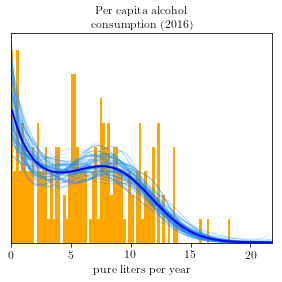

In [41]:
sw.demo()

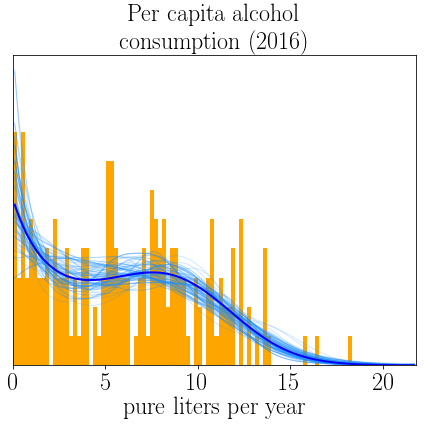

In [42]:
dataset = sw.ExampleDataset('who.alcohol_consumption')
density = sw.DensityEstimator(dataset.data)
density.plot(title=dataset.description, xlabel=dataset.units, figsize=[6,6], fontsize=24, save_as='figures/fig_alcohol.pdf')
plt.show()

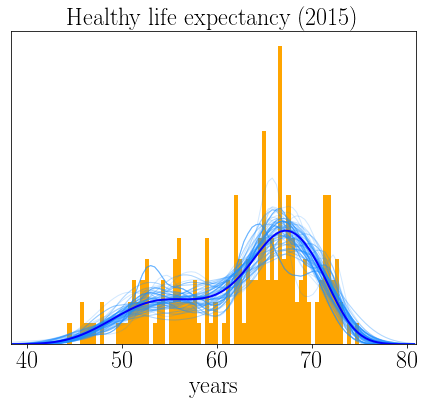

In [44]:
dataset = sw.ExampleDataset('who.life_expectancy_healthy')
density = sw.DensityEstimator(dataset.data, alpha=3)
density.plot(title=dataset.description, xlabel=dataset.units, figsize=[6,5.7], fontsize=24, save_as='figures/fig_lifeexpectancy.pdf')
plt.show()

In [32]:
sw.ExampleDataset.list()

['buffalo_snowfall',
 'old_faithful_eruption_times',
 'old_faithful_waiting_times',
 'treatment_length',
 'who.adolescent_births',
 'who.air_pollution_mortality',
 'who.alcohol_consumption',
 'who.attended_births',
 'who.cause_of_death_known',
 'who.child_overweight',
 'who.child_stunting',
 'who.child_wasting',
 'who.clean_fuels',
 'who.clean_water',
 'who.conflict_deaths',
 'who.dpt_immunization',
 'who.early_disease_deaths',
 'who.family_planning',
 'who.govt_expendature',
 'who.health_and_research',
 'who.health_professionals',
 'who.hepatitis_vaccine',
 'who.hiv_infections',
 'who.homicide',
 'who.life_expectancy',
 'who.life_expectancy_female',
 'who.life_expectancy_healthy',
 'who.life_expectancy_male',
 'who.malaria_incidence',
 'who.maternal_mortality',
 'who.natural_disasters',
 'who.neonatal_moratlity',
 'who.ntd_interventions',
 'who.particulate_matter',
 'who.poisoning_mortality',
 'who.population',
 'who.sanitation',
 'who.score_avg',
 'who.smoking_female',
 'who.smoking_